In [86]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.pipeline import make_pipeline, _name_estimators
from sklearn.decomposition import PCA, KernelPCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, make_scorer, f1_score, precision_score, recall_score, accuracy_score, roc_curve, auc, roc_auc_score
from scipy import interp
from sklearn.base import clone, ClassifierMixin, BaseEstimator
from itertools import combinations
import operator

In [87]:
#dataset

In [88]:
df_magic = pd.read_csv('magic04.data', header = None)
df_magic.columns = ['Lenght', 'Width', 'Size', 'Conc', 'Conc1', 'Asym', 'M3Long', 'M3Trans', 'Alpha', 'Dist', 'Class']
le = LabelEncoder()
y = le.fit_transform(df_magic['Class'].values)
df_magic['Class'] = y

In [89]:
df_magic

,Lenght,Width,Size,Conc,Conc1,Asym,M3Long,M3Trans,Alpha,Dist,Class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,0
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,0
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,0
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,0
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,0
...,...,...,...,...,...,...,...,...,...,...,...
19015,21.3846,10.9170,2.6161,0.5857,0.3934,15.2618,11.5245,2.8766,2.4229,106.8258,1
19016,28.9452,6.7020,2.2672,0.5351,0.2784,37.0816,13.1853,-2.9632,86.7975,247.4560,1
19017,75.4455,47.5305,3.4483,0.1417,0.0549,-9.3561,41.0562,-9.4662,30.2987,256.5166,1
19018,120.5135,76.9018,3.9939,0.0944,0.0683,5.8043,-93.5224,-63.8389,84.6874,408.3166,1


In [90]:
X,y  = df_magic.iloc[:,:-1].values, df_magic.iloc[:,-1].values
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size= 0.3, random_state= 0, stratify= y, shuffle= True)
X_train = X_train[:500]
X_test = X_test[:150]
y_train = y_train[:500]
y_test = y_test[:150]

In [91]:
#funzioni che utilizzeremo

In [92]:
def ROC_Curve(X,y, estimator):
    cv = list(StratifiedKFold(n_splits  = 10, random_state = 1, shuffle= True).split(X, y))
    fig  = plt.figure(figsize = (7,5))
    mean_tpr = 0.0
    mean_fpr = np.linspace(0,1,100)
    all_tpr = []

    for i, (train, test) in enumerate(cv):
        probas = estimator.fit(X[train], y[train]).predict_proba(X_train[test])
        fpr, tpr, thresholds = roc_curve(y[test], probas[:,1],pos_label= 1)
        mean_tpr += np.interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr,tpr)
        plt.plot(fpr,tpr, label = 'ROC fold %d (area = %0.2f)' % (i+1, roc_auc))
    plt.plot([0,1], [0,1], linestyle = '--', color = (0.6,0.6,0.6), label = 'Random guessing')
    mean_tpr /= len(cv)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, 'k--', label = 'Mean ROC (area = %0.2f)' % mean_auc, lw = 2)
    plt.plot([0,0,1], [0,1,1], linestyle = ':', label = 'Perfect performance')
    plt.xlim([-0.05,1.05])
    plt.ylim([-0.05,1.05])
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.legend(loc = 'lower right')
    plt.show()


In [93]:
class SBS():
    def __init__(self, estimator, k_features, scoring = accuracy_score, test_size = 0.25, random_state = 1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state
    def fit(self, X,y):
        X_train, X_test, y_train, y_test = train_test_split(X,y, test_size= 0.3, random_state= self.random_state)
        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train,y_train, X_test, y_test,self.indices_)
        self.scores_ = [score]
        
        while dim > self.k_features:
            scores = []
            subsets = []
            
            for p in combinations(self.indices_, r = dim-1):
                score = self._calc_score(X_train, y_train, X_test, y_test, p)

                scores.append(score)
                subsets.append(p)
            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1
            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]
        return self
    
    def transform(self,X):
        return X[:, self.indices_]
    
    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score  

In [94]:
scorer_f1 = make_scorer(f1_score, pos_label = 0)

In [95]:
#SCALING

In [96]:
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

In [97]:
#KNN

In [98]:
knn = KNeighborsClassifier(n_neighbors=5, p=2, metric='minkowski')
pipe_knn = make_pipeline(knn)
n_neighbors = [3,5,7] #valori a caso
param_grid_knn = [{'kneighborsclassifier__n_neighbors': n_neighbors, 'kneighborsclassifier__metric': ['minkowski']}]

#accuracy
gs_knn_acc = GridSearchCV(estimator= pipe_knn, param_grid = param_grid_knn, scoring = 'accuracy', refit = True, cv  = 10, n_jobs= -1)
gs_knn_acc.fit(X_train, y_train)
best_knn_acc = gs_knn_acc.best_estimator_
best_knn_acc.fit(X_train, y_train)
print(gs_knn_acc.best_params_)
scores = cross_val_score(estimator= best_knn_acc, X = X_train, y = y_train, cv =10)
print('Score valutato con la k-fold validation:', np.mean(scores), gs_knn_acc.best_score_)
print('Accuracy del modello valutato sul test data', best_knn_acc.score(X_test, y_test))
print('Accuracy del modello valutato sul train data', best_knn_acc.score(X_train, y_train))



{'kneighborsclassifier__metric': 'minkowski', 'kneighborsclassifier__n_neighbors': 7}
Score valutato con la k-fold validation: 0.74 0.74
Accuracy del modello valutato sul test data 0.8
Accuracy del modello valutato sul train data 0.808


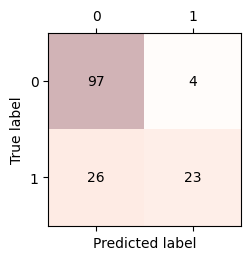

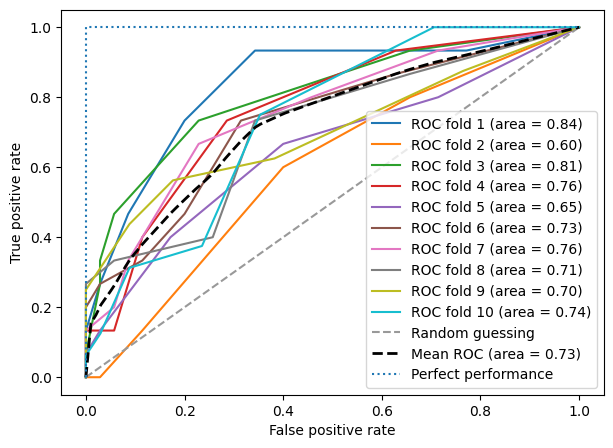

ROC auc score with accuracy 0.8394625176803394


In [99]:
confmat = confusion_matrix(y_true = y_test, y_pred = best_knn_acc.predict(X_test))
fig, ax = plt.subplots(figsize = (2.5,2.5))
ax.matshow(confmat, cmap = plt.cm.Reds, alpha =0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x= j, y= i, s= confmat[i,j], va = 'center', ha = 'center')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

ROC_Curve(X_train, y_train, best_knn_acc)
print('ROC auc score with accuracy', roc_auc_score(y_true=  y_test, y_score= best_knn_acc.predict_proba(X_test)[:,1]))


In [100]:
#f1 score

gs_knn_f1 = GridSearchCV(estimator= pipe_knn, param_grid= param_grid_knn, cv = 10, scoring= scorer_f1, n_jobs= -1)
gs_knn_f1.fit(X_train, y_train)
best_knn_f1 = gs_knn_f1.best_estimator_
best_knn_f1.fit(X_train, y_train)
print(gs_knn_f1.best_params_)
scores = cross_val_score(estimator= best_knn_f1, X= X_train, y = y_train, cv = 10, scoring= scorer_f1)
print('CV accuracy:', np.mean(scores), gs_knn_f1.best_score_)
print('Accuracy on test data:', scorer_f1(best_knn_f1, X_test, y_test))
print('Accuracy on train data:', scorer_f1(best_knn_f1, X_train, y_train))

{'kneighborsclassifier__metric': 'minkowski', 'kneighborsclassifier__n_neighbors': 7}
CV accuracy: 0.8318394272696124 0.8318394272696124
Accuracy on test data: 0.8660714285714286
Accuracy on train data: 0.87467362924282


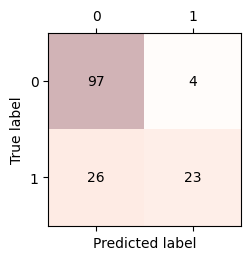

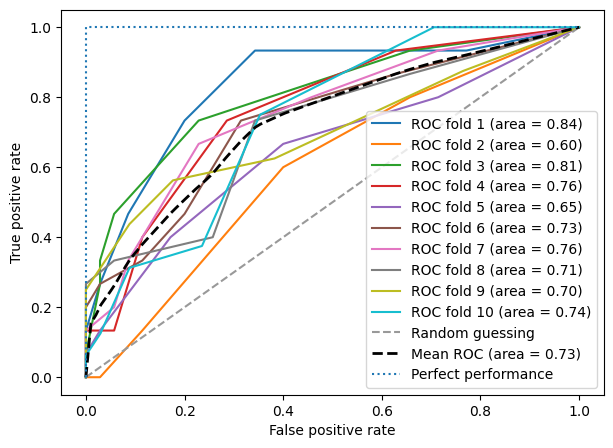

ROC auc score with accuracy 0.8394625176803394


In [101]:
confmat = confusion_matrix(y_true = y_test, y_pred = best_knn_f1.predict(X_test))
fig, ax = plt.subplots(figsize = (2.5,2.5))
ax.matshow(confmat, cmap = plt.cm.Reds, alpha =0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x= j, y= i, s= confmat[i,j], va = 'center', ha = 'center')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

ROC_Curve(X_train, y_train, best_knn_f1)
print('ROC auc score with accuracy', roc_auc_score(y_true = y_test, y_score= best_knn_f1.predict_proba(X_test)[:,1]))


In [102]:
#escono risultati identici per la accuracy e per la f1, o è un caso oppure è da rivedere

In [103]:
#knn + PCA

In [104]:
pca = PCA(n_components = None)
X_train_2, X_val, y_train_2, y_val = train_test_split(X_train_std, y_train, test_size= 0.3, random_state= 0, stratify= y_train)
pca.fit(X_train_2)

PCA()

In [105]:
n_neighbors = [3,5,7]
n_components=[5,6,7]
pipe_knn_pca = make_pipeline(StandardScaler(), pca, knn)
param_grid_knn_pca = [{'kneighborsclassifier__n_neighbors': n_neighbors, 'kneighborsclassifier__metric': ['minkowski'], 'pca__n_components': n_components}, 
{'kneighborsclassifier__n_neighbors': n_neighbors, 'kneighborsclassifier__metric': ['euclidean'], 'pca__n_components':n_components}]

#accuracy
gs_knn_pca_acc = GridSearchCV(estimator= pipe_knn_pca, param_grid = param_grid_knn_pca, scoring = 'accuracy',cv  = 10, n_jobs= -1)
gs_knn_pca_acc.fit(X_train, y_train)
best_knn_pca_acc = gs_knn_pca_acc.best_estimator_
best_knn_pca_acc.fit(X_train, y_train)
print(gs_knn_pca_acc.best_params_)
scores = cross_val_score(estimator= best_knn_pca_acc, X = X_train, y = y_train, cv =10)
print('Score valutato con la k-fold validation:', np.mean(scores), gs_knn_pca_acc.best_score_)
print('Accuracy del modello valutato sul test data', best_knn_pca_acc.score(X_test, y_test))
print('Accuracy del modello valutato sul train data', best_knn_pca_acc.score(X_train, y_train))

{'kneighborsclassifier__metric': 'minkowski', 'kneighborsclassifier__n_neighbors': 7, 'pca__n_components': 5}
Score valutato con la k-fold validation: 0.8019999999999999 0.8019999999999999
Accuracy del modello valutato sul test data 0.7933333333333333
Accuracy del modello valutato sul train data 0.84


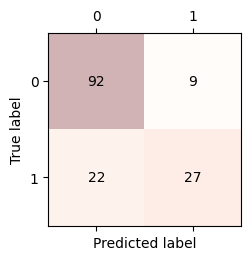

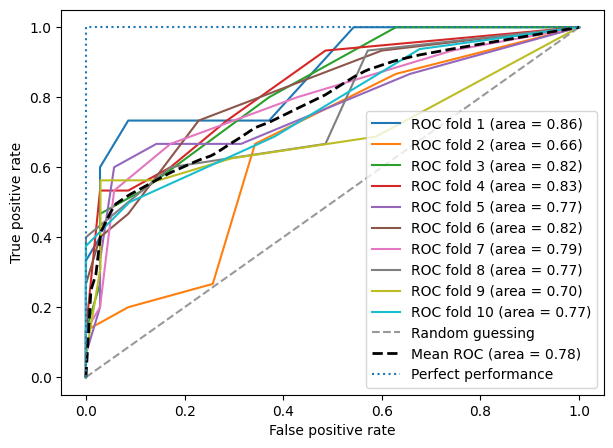

ROC auc score with accuracy 0.8424934330167712


In [106]:
confmat = confusion_matrix(y_true = y_test, y_pred = best_knn_pca_acc.predict(X_test))
fig, ax = plt.subplots(figsize = (2.5,2.5))
ax.matshow(confmat, cmap = plt.cm.Reds, alpha =0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x= j, y= i, s= confmat[i,j], va = 'center', ha = 'center')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

ROC_Curve(X_train, y_train, best_knn_pca_acc)
print('ROC auc score with accuracy', roc_auc_score(y_true= y_test, y_score= best_knn_pca_acc.predict_proba(X_test)[:,1]))


In [107]:
#f1 score

In [108]:
gs_knn_pca_f1 = GridSearchCV(estimator= pipe_knn_pca, param_grid= param_grid_knn_pca, cv = 10, scoring= scorer_f1, n_jobs= -1)
gs_knn_pca_f1.fit(X_train, y_train)
best_knn_pca_f1 = gs_knn_pca_f1.best_estimator_
best_knn_pca_f1.fit(X_train, y_train)
print(gs_knn_pca_f1.best_params_)
scores = cross_val_score(estimator= best_knn_pca_f1, X= X_train, y = y_train, cv = 10, scoring= scorer_f1)
print('CV accuracy:', np.mean(scores), gs_knn_pca_f1.best_score_)
print('Accuracy on test data:', scorer_f1(best_knn_pca_f1, X_test, y_test))
print('Accuracy on train data:', scorer_f1(best_knn_pca_f1, X_train, y_train))

{'kneighborsclassifier__metric': 'minkowski', 'kneighborsclassifier__n_neighbors': 7, 'pca__n_components': 5}
CV accuracy: 0.8707937735719214 0.8707937735719214
Accuracy on test data: 0.8558139534883721
Accuracy on train data: 0.8936170212765958


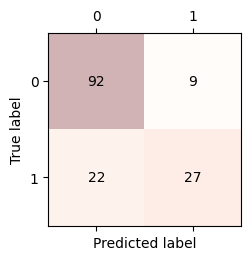

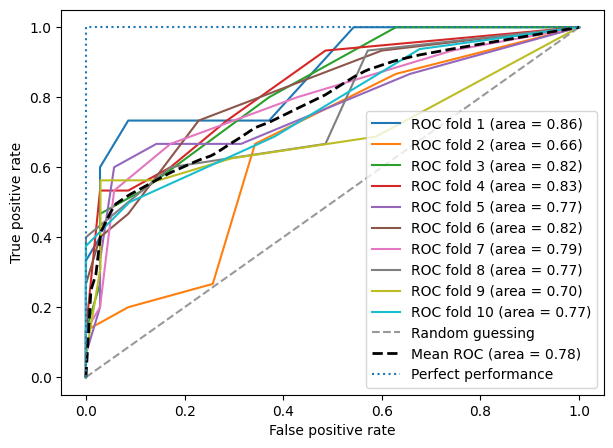

ROC auc score with accuracy 0.8424934330167712


In [109]:
confmat = confusion_matrix(y_true = y_test, y_pred = best_knn_pca_f1.predict(X_test))
fig, ax = plt.subplots(figsize = (2.5,2.5))
ax.matshow(confmat, cmap = plt.cm.Reds, alpha =0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x= j, y= i, s= confmat[i,j], va = 'center', ha = 'center')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

ROC_Curve(X_train, y_train, best_knn_pca_f1)
print('ROC auc score with accuracy', roc_auc_score(y_true = y_test, y_score= best_knn_pca_f1.predict_proba(X_test)[:,1]))


In [110]:
#knn + feature selection

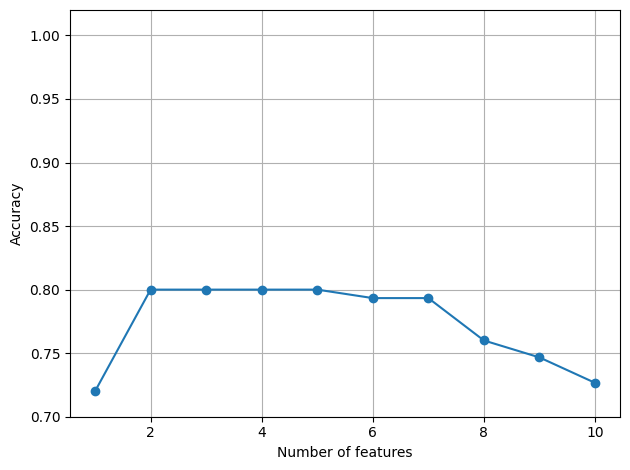

In [111]:
n_neighbors = [3,5,7]
n_components=[5,6,7]
#pipe_knn_pca = make_pipeline(StandardScaler(), pca, knn)
param_grid_knn_sbs = [{'kneighborsclassifier__n_neighbors': n_neighbors, 'kneighborsclassifier__metric': ['minkowski']}, 
{'kneighborsclassifier__n_neighbors': n_neighbors, 'kneighborsclassifier__metric': ['euclidean']}]
sbs = SBS(knn, k_features= 1)
sbs.fit(X_train, y_train)
k_feat  = [len(k) for k in sbs.subsets_]
plt.plot(k_feat, sbs.scores_, marker = 'o')
plt.ylim([0.7,1.02])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.tight_layout()
plt.show()


In [112]:
sbs_5 = SBS(knn, k_features = 4)
pipe_knn_sbs_acc = make_pipeline(StandardScaler(), sbs_5, knn)
gs_knn_sbs_acc = GridSearchCV(estimator= pipe_knn_sbs_acc, param_grid = param_grid_knn_sbs, scoring = 'accuracy', cv  = 10, n_jobs= -1)
gs_knn_sbs_acc.fit(X_train, y_train)


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('sbs',
                                        <__main__.SBS object at 0x127085940>),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid=[{'kneighborsclassifier__metric': ['minkowski'],
                          'kneighborsclassifier__n_neighbors': [3, 5, 7]},
                         {'kneighborsclassifier__metric': ['euclidean'],
                          'kneighborsclassifier__n_neighbors': [3, 5, 7]}],
             scoring='accuracy')

In [113]:
best_knn_sbs_acc = gs_knn_sbs_acc.best_estimator_
best_knn_sbs_acc.fit(X_train, y_train)
print(gs_knn_sbs_acc.best_params_)
scores = cross_val_score(estimator= best_knn_sbs_acc, X = X_train, y = y_train, cv =10, n_jobs= -1)
print('Score valutato con la k-fold validation:', np.mean(scores), gs_knn_sbs_acc.best_score_)
print('Accuracy del modello valutato sul test data', best_knn_sbs_acc.score(X_test, y_test))
print('Accuracy del modello valutato sul train data', best_knn_sbs_acc.score(X_train, y_train))

{'kneighborsclassifier__metric': 'minkowski', 'kneighborsclassifier__n_neighbors': 7}
Score valutato con la k-fold validation: 0.8220000000000001 0.8220000000000001
Accuracy del modello valutato sul test data 0.7933333333333333
Accuracy del modello valutato sul train data 0.866


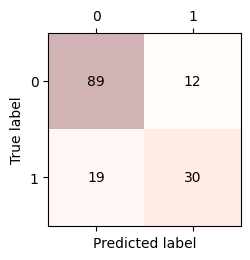

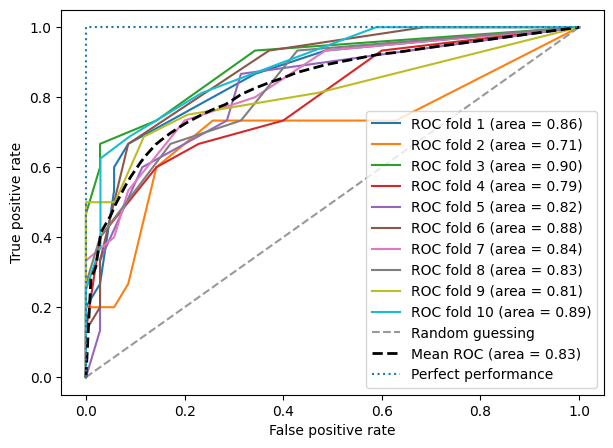

ROC auc score with accuracy 0.8346130531420488


In [114]:
confmat = confusion_matrix(y_true = y_test, y_pred = best_knn_sbs_acc.predict(X_test))
fig, ax = plt.subplots(figsize = (2.5,2.5))
ax.matshow(confmat, cmap = plt.cm.Reds, alpha =0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x= j, y= i, s= confmat[i,j], va = 'center', ha = 'center')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

ROC_Curve(X_train, y_train, best_knn_sbs_acc)
print('ROC auc score with accuracy', roc_auc_score(y_true = y_test, y_score= best_knn_sbs_acc.predict_proba(X_test)[:,1]))


In [115]:
#f1 score
pipe_knn_sbs_f1 = make_pipeline(StandardScaler(), sbs_5, knn)
gs_knn_sbs_f1 = GridSearchCV(estimator= pipe_knn_sbs_f1, param_grid = param_grid_knn_sbs, scoring = scorer_f1, cv  = 10, n_jobs= -1)
gs_knn_sbs_f1.fit(X_train, y_train)
best_knn_sbs_f1 = gs_knn_sbs_f1.best_estimator_
best_knn_sbs_f1.fit(X_train, y_train)
print(gs_knn_sbs_f1.best_params_)
scores = cross_val_score(estimator= best_knn_sbs_f1, X= X_train, y = y_train, cv = 10, scoring= scorer_f1)
print('CV accuracy:', np.mean(scores), gs_knn_sbs_f1.best_score_)
print('Accuracy on test data:', scorer_f1(best_knn_sbs_f1, X_test, y_test))
print('Accuracy on train data:', scorer_f1(best_knn_sbs_f1, X_train, y_train))


{'kneighborsclassifier__metric': 'minkowski', 'kneighborsclassifier__n_neighbors': 7}
CV accuracy: 0.882379100431732 0.882379100431732
Accuracy on test data: 0.8516746411483254
Accuracy on train data: 0.9103078982597055


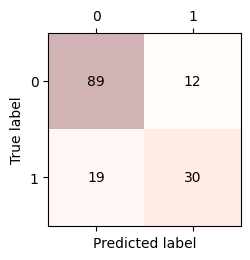

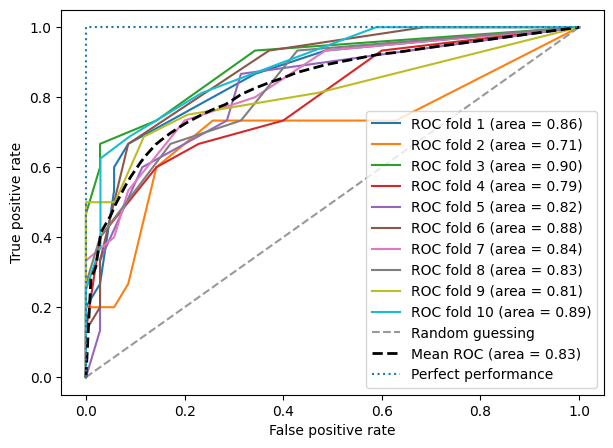

ROC auc score with accuracy 0.8346130531420488


In [116]:
confmat = confusion_matrix(y_true = y_test, y_pred = best_knn_sbs_f1.predict(X_test))
fig, ax = plt.subplots(figsize = (2.5,2.5))
ax.matshow(confmat, cmap = plt.cm.Reds, alpha =0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x= j, y= i, s= confmat[i,j], va = 'center', ha = 'center')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

ROC_Curve(X_train, y_train, best_knn_sbs_f1)
print('ROC auc score with accuracy', roc_auc_score(y_true = y_test, y_score= best_knn_sbs_f1.predict_proba(X_test)[:,1]))


In [117]:
#knn + KPCA

In [121]:
kpca = KernelPCA(kernel= 'rbf')
pipe_knn_kpca = make_pipeline(StandardScaler(),kpca, knn)
n_neighbors = [3,5,7]
n_components=[5,6,7]
param_grid_knn_kpca = [{'kneighborsclassifier__n_neighbors': n_neighbors, 'kneighborsclassifier__metric': ['minkowski'], 'kernelpca__n_components': n_components}, 
{'kneighborsclassifier__n_neighbors': n_neighbors, 'kneighborsclassifier__metric': ['euclidean'], 'kernelpca__n_components':n_components}]
#accuracy
gs_knn_kpca_acc = GridSearchCV(estimator= pipe_knn_kpca, param_grid= param_grid_knn_kpca, cv = 10, scoring= 'accuracy', n_jobs= -1)
gs_knn_kpca_acc.fit(X_train, y_train)
best_knn_kpca_acc = gs_knn_kpca_acc.best_estimator_
best_knn_kpca_acc.fit(X_train, y_train)
scores = cross_val_score(estimator= best_knn_kpca_acc, X = X_train, y = y_train, cv = 10)
print('Score valutato con la k-fold validation:', np.mean(scores), gs_knn_kpca_acc.best_score_)
print('Accuracy del modello sul test data:', best_knn_kpca_acc.score(X_test, y_test))
print('Accuracy del modello sul train data:', best_knn_kpca_acc.score(X_train, y_train))


Score valutato con la k-fold validation: 0.8 0.8
Accuracy del modello sul test data: 0.76
Accuracy del modello sul train data: 0.846


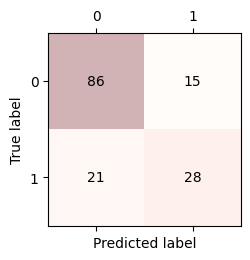

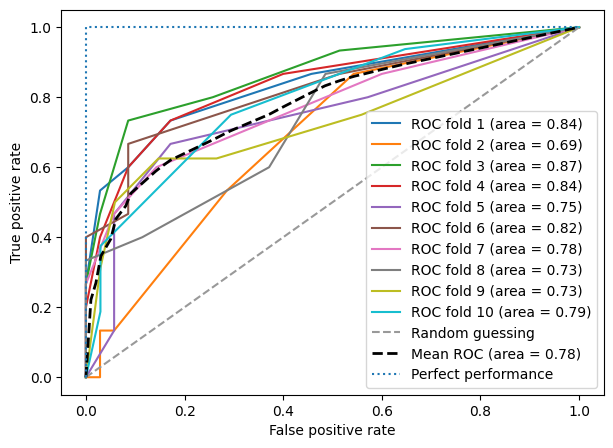

ROC auc score with accuracy 0.8075368761365932


In [122]:
confmat = confusion_matrix(y_true = y_test, y_pred = best_knn_kpca_acc.predict(X_test))
fig, ax = plt.subplots(figsize = (2.5,2.5))
ax.matshow(confmat, cmap = plt.cm.Reds, alpha =0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x= j, y= i, s= confmat[i,j], va = 'center', ha = 'center')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

ROC_Curve(X_train, y_train, best_knn_kpca_acc)
print('ROC auc score with accuracy', roc_auc_score(y_true = y_test, y_score= best_knn_kpca_acc.predict_proba(X_test)[:,1]))


In [123]:
#f1 score

gs_knn_kpca_f1 = GridSearchCV(estimator= pipe_knn_kpca, param_grid= param_grid_knn_kpca, cv = 10, scoring= scorer_f1, n_jobs= -1)
gs_knn_kpca_f1.fit(X_train, y_train)
best_knn_kpca_f1 = gs_knn_kpca_f1.best_estimator_
best_knn_kpca_f1.fit(X_train, y_train)
print(gs_knn_kpca_f1.best_params_)
scores = cross_val_score(estimator= best_knn_kpca_f1, X= X_train, y = y_train, cv = 10, scoring= scorer_f1)
print('CV accuracy:', np.mean(scores), gs_knn_kpca_f1.best_score_)
print('Accuracy on test data:', scorer_f1(best_knn_kpca_f1, X_test, y_test))
print('Accuracy on train data:', scorer_f1(best_knn_kpca_f1, X_train, y_train))


{'kernelpca__n_components': 5, 'kneighborsclassifier__metric': 'minkowski', 'kneighborsclassifier__n_neighbors': 7}
CV accuracy: 0.8631740243319191 0.8631740243319191
Accuracy on test data: 0.8405797101449276
Accuracy on train data: 0.8853333333333333


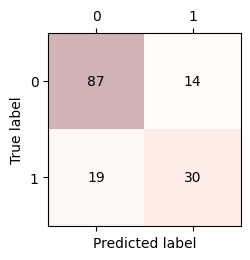

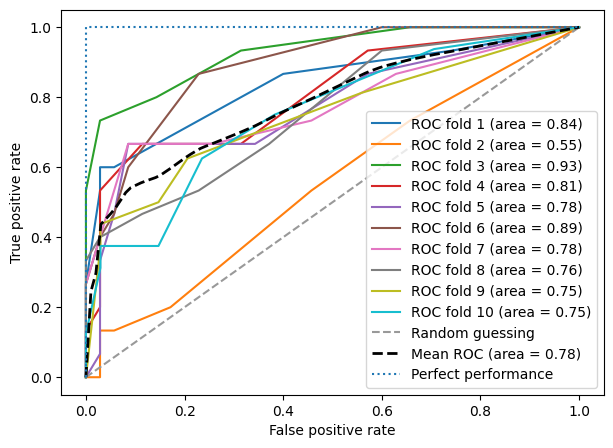

ROC auc score with accuracy 0.8109719135178823


In [124]:
confmat = confusion_matrix(y_true = y_test, y_pred = best_knn_kpca_f1.predict(X_test))
fig, ax = plt.subplots(figsize = (2.5,2.5))
ax.matshow(confmat, cmap = plt.cm.Reds, alpha =0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x= j, y= i, s= confmat[i,j], va = 'center', ha = 'center')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

ROC_Curve(X_train, y_train, best_knn_kpca_f1)
print('ROC auc score with accuracy', roc_auc_score(y_true = y_test, y_score= best_knn_kpca_f1.predict_proba(X_test)[:,1]))
